In [3]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

In [4]:
pickle_file = 'brData10ClassSimple.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (100000, 28, 28) (100000,)
Test set (1000, 28, 28) (1000,)


In [5]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

print ()

Training set (100000, 28, 28, 1) (100000, 10)
Test set (1000, 28, 28, 1) (1000, 10)



In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [34]:
batch_size = 100
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.tanh(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.tanh(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.tanh(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.005).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 0.202833
Minibatch accuracy: 12.0%
Minibatch loss at step 20: 0.131521
Minibatch accuracy: 14.0%
Minibatch loss at step 40: 0.089391
Minibatch accuracy: 38.0%
Minibatch loss at step 60: 0.066866
Minibatch accuracy: 91.0%
Minibatch loss at step 80: 0.058535
Minibatch accuracy: 99.0%
Minibatch loss at step 100: 0.034769
Minibatch accuracy: 100.0%
Minibatch loss at step 120: 0.022911
Minibatch accuracy: 100.0%
Minibatch loss at step 140: 0.026871
Minibatch accuracy: 100.0%
Minibatch loss at step 160: 0.017902
Minibatch accuracy: 100.0%
Minibatch loss at step 180: 0.026693
Minibatch accuracy: 100.0%
Minibatch loss at step 200: 0.018980
Minibatch accuracy: 100.0%
Minibatch loss at step 220: 0.021676
Minibatch accuracy: 100.0%
Minibatch loss at step 240: 0.026092
Minibatch accuracy: 100.0%
Minibatch loss at step 260: 0.011171
Minibatch accuracy: 100.0%
Minibatch loss at step 280: 0.018880
Minibatch accuracy: 100.0%
Minibatch loss at step 300: 0.025506
Mi

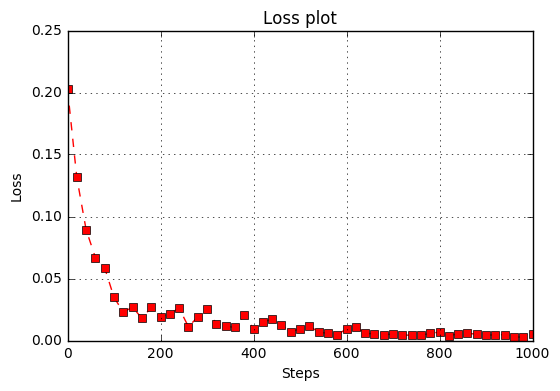

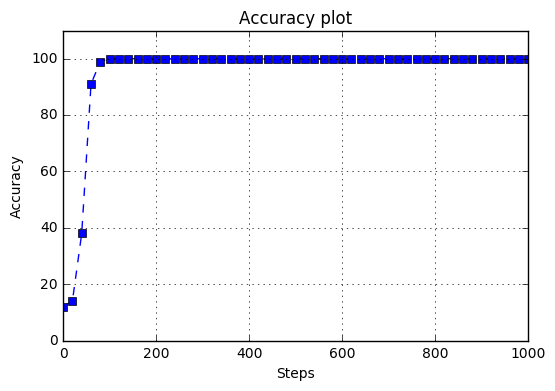

In [35]:
num_steps = 1001
step_plot = []
loss_plot = []
accuracy_plot = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 20 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      acc = accuracy(predictions, batch_labels)
      print('Minibatch accuracy: %.1f%%' % acc)
      step_plot.append(step)
      loss_plot.append(l)
      accuracy_plot.append(acc)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  plt.plot(step_plot, loss_plot, 'rs--')
  plt.xlabel('Steps')
  plt.ylabel('Loss')
  plt.title('Loss plot')
  plt.grid(True)
  plt.show()
  plt.plot(step_plot, accuracy_plot, '--bs')
  plt.xlabel('Steps')
  plt.ylabel('Accuracy')
  plt.title('Accuracy plot')
  plt.axis([0, 1000, 0, 110])
  plt.grid(True)
  plt.show()

In [50]:
batch_size = 128
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    shape = pool.get_shape().as_list()
    print (shape)
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.00005).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  test_prediction = tf.nn.softmax(model(tf_test_dataset))



[128, 7, 7, 16]
[1000, 7, 7, 16]


In [51]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :plt.axis([0, 1100, 0, 110])plt.axis([0, 1100, 0, 110])]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 0.129232
Minibatch accuracy: 13.3%
Minibatch loss at step 50: nan
Minibatch accuracy: 100.0%
Minibatch loss at step 100: nan
Minibatch accuracy: 100.0%
Minibatch loss at step 150: nan
Minibatch accuracy: 100.0%
Minibatch loss at step 200: nan
Minibatch accuracy: 100.0%
Minibatch loss at step 250: nan
Minibatch accuracy: 100.0%
Minibatch loss at step 300: nan
Minibatch accuracy: 100.0%
Minibatch loss at step 350: nan
Minibatch accuracy: 100.0%
Minibatch loss at step 400: nan
Minibatch accuracy: 100.0%
Minibatch loss at step 450: nan
Minibatch accuracy: 100.0%
Minibatch loss at step 500: nan
Minibatch accuracy: 100.0%
Minibatch loss at step 550: nan
Minibatch accuracy: 100.0%
Minibatch loss at step 600: nan
Minibatch accuracy: 100.0%
Minibatch loss at step 650: nan
Minibatch accuracy: 100.0%
Minibatch loss at step 700: nan
Minibatch accuracy: 100.0%
Minibatch loss at step 750: nan
Minibatch accuracy: 100.0%
Minibatch loss at step 800: nan
Minibatch a

In [64]:
batch_size = 150
patch_size = 5
depth = 16
num_hidden = 64

num_steps = 0 # Needed for learning rate decay

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data, train=True):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    shape = pool.get_shape().as_list()
    print (shape)
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    if (train):
        hidden = tf.nn.dropout(hidden, 0.5)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  starting_learning_rate = 0.000005
  #learning_rate = tf.train.exponential_decay(starting_learning_rate, num_steps, 2001, 0.95, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(starting_learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  test_prediction = tf.nn.softmax(model(tf_test_dataset, False))

[150, 7, 7, 16]
[1000, 7, 7, 16]


In [65]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 0.591386
Minibatch accuracy: 0.0%
Minibatch loss at step 50: 0.291228
Minibatch accuracy: 4.7%
Minibatch loss at step 100: 0.364766
Minibatch accuracy: 6.0%
Minibatch loss at step 150: 0.506805
Minibatch accuracy: 3.3%
Minibatch loss at step 200: 0.483754
Minibatch accuracy: 8.0%
Minibatch loss at step 250: 0.302234
Minibatch accuracy: 6.7%
Minibatch loss at step 300: 0.582286
Minibatch accuracy: 5.3%
Minibatch loss at step 350: 0.530859
Minibatch accuracy: 3.3%
Minibatch loss at step 400: 0.477240
Minibatch accuracy: 10.0%
Minibatch loss at step 450: 0.283908
Minibatch accuracy: 6.7%
Minibatch loss at step 500: 0.289842
Minibatch accuracy: 6.7%
Minibatch loss at step 550: 0.448709
Minibatch accuracy: 6.7%
Minibatch loss at step 600: 0.339876
Minibatch accuracy: 7.3%
Minibatch loss at step 650: 0.227795
Minibatch accuracy: 6.7%
Minibatch loss at step 700: 0.195998
Minibatch a